In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
import random

In [166]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

In [167]:
def plotHiperplano(X,y,vetor,intercept=0):
  x0min = min(X[:,0])
  x0max = max(X[:,0])
  xs = np.linspace(x0min,x0max,num=2)
  ys = (- vetor[0]/vetor[1])*xs-intercept/vetor[1]
  plt.plot(xs,ys)

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

#plotDataset(Xtr,ytr)

In [168]:
class Perceptron (BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000):
    self.w = None# np.array([1,-1])
    self.activation=lambda a:(a>0)*2 -1
    self.max_iter = max_iter
    self.history = []

  #Funcao de FIT com selector de estrategia de custo batch/online
  def fit(self,X,y,batch=True):
    Xb = Perceptron.includebias(X)
    if batch:
      return self.fit_batch(Xb,y)
    else:
      return self.fit_online(Xb,y)

  #Fit online  
  def fit_online(self,X,y):
    self.w = np.random.uniform(-1,1,size=X.shape[1])
    indexs = list(range(X.shape[0]))
    
    for j in range(self.max_iter):
      any_error = False
      custo=0
      for i in sorted(indexs,key=lambda k:random.random()):
        x = X[i,:]
        ypred = self.predict(x[1:])
        erro = y[i] - ypred #-1+1#1+1#-1-1
        custo += erro**2
        if erro !=0:
          any_error = True
        self.w = self.w + erro * x
      self.history.append(custo)
      if not any_error:
        print(j)
        break
    return(self.history)
  
  #Fit em batch
  def fit_batch(self,X,y):
    self.w = np.random.uniform(-1,1,size=X.shape[1])
    #indexs = list(range(X.shape[0]))
    for j in range(self.max_iter):
      ypred = self.predict(X[:,1:])
      erros = y - ypred
      custo = np.sum(erros**2)
      if custo == 0:
        print(j)
        self.history.append(custo)
        break
      self.w += X.T @ erros
      self.history.append(custo)
    print(j)
    return self.history

  @staticmethod
  def includebias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

  def predict(self,X,y=None):
    Xb = Perceptron.includebias(X)
    a = Xb @ self.w
    ypred = self.activation(a)
    return ypred


def plotHistory(hist):
   plt.plot(hist)

((20, 2), (20,))

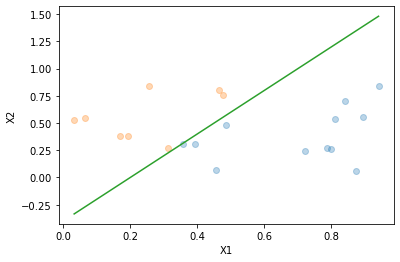

In [169]:
Xtr,ytr = criaDataset()
plotDataset(Xtr,ytr)
#plt.show()
plotHiperplano(Xtr,ytr,np.array([2,-1]),-0.4)
Xtr.shape,ytr.shape

31
31
1.0
[ -4.06881752  28.52119364 -19.68045173]


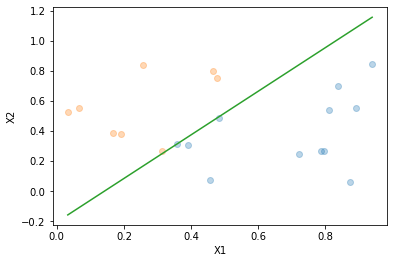

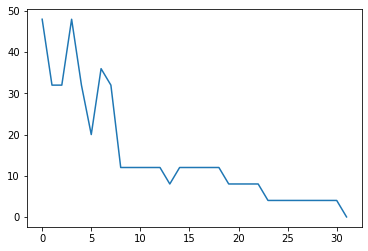

In [170]:
perceptron = Perceptron()
history = perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)

0.952
[ -4.06881752  28.52119364 -19.68045173]


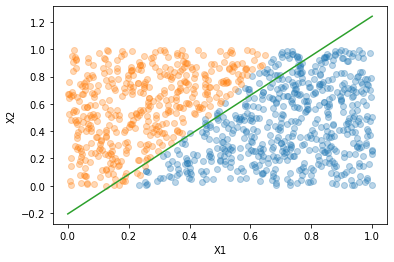

In [171]:
Xtst,ytst = criaDataset(n=1000)
ypred = perceptron.predict(Xtst)
print(sum(ypred==ytst)/len(ytst))
print(perceptron.w)
plotDataset(Xtst,ytst)
plotHiperplano(Xtst,ytst,perceptron.w[1:],perceptron.w[0])

# Estratégia ADALINE (Com regressão linear)

In [172]:
def criaDatasetReg(n=20,slop=0.5,intercept=0.2):
  X = np.random.uniform(size=(n,1))
  AUX = np.random.rand(n,1)-0.5
  y = X*slop + intercept + AUX*0.1
  y = y.flatten()
  return X,y

def plotaDatasetRegr(X,y):
  plt.plot(X[:,0],y,"o",alpha=0.3)

def plotaFuncao(X,y,slop,intercept=0):
  xmin = min(X)
  xmax = max(X)
  xs = np.linspace(xmin,xmax,num=2)
  ys = xs*slop + intercept
  plt.plot(xs,ys)

In [243]:
class Perceptron (BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000,learning_rate=0.05,early_stop=0.1):
    self.w = None# np.array([1,-1])
    self.activation = lambda a: (a>0)*2 -1
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.early_stop = 0.1
    self.history = []
  
  def __pre_activation(self,X):
    Xb = Perceptron.includebias(X)
    ypred = Xb @ self.w
    return ypred

  #Funcao de FIT com selector de estrategia de custo batch/online
  def fit(self,X,y,batch=True,pinv=False):
    Xb = Perceptron.includebias(X)
    if batch:
      return self.fit_batch(Xb,y)
    elif pinv:
      return self.fit_pseudoinv(Xb,y)
    else:
      return self.fit_online(Xb,y)

  #Fit online  
  def fit_online(self,X,y):
    self.w = np.random.uniform(-1,1,size=X.shape[1])
    indexs = list(range(X.shape[0]))
    
    for j in range(self.max_iter):
      any_error = False
      custo=0
      for i in sorted(indexs,key=lambda k:random.random()):
        x = X[i,:]
        ypred = self.predict(x[1:])
        erro = y[i] - ypred #-1+1#1+1#-1-1
        custo += erro**2
        if erro !=0:
          any_error = True
        self.w = self.w + erro * x
      self.history.append(custo)
      if not any_error:
        print(j)
        break
    return(self.history)
  
  #Fit em batch
  def fit_batch(self,X,y):
    self.w = np.random.uniform(-1,1,size=X.shape[1])
    #indexs = list(range(X.shape[0]))
    for j in range(self.max_iter):
      ypred = self.__pre_activation(X[:,1:])
      erros = y - ypred
      custo = np.sum(erros**2)
      if custo <= self.early_stop: #== 0:
        print("DEBUG: EARLY_STOP ",custo)
        self.history.append(custo)
        break
      self.w += (X.T @ erros) * self.learning_rate
      self.history.append(custo)
      #print("DEBUG",custo)
    #print(j)
    return self.history
  
  def fit_pseudoinv(self,X,y):
    print("DEBUG: PSEUDOINV ")
    self.w = np.linalg.pinv(X) @ y
    return self.history

  @staticmethod
  def includebias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

  def predict(self,X,y=None):
    a = self.__pre_activation(X)
    ypred = self.activation(a)
    return ypred


def plotHistory(hist):
   plt.plot(hist)

((20, 1), (20,))

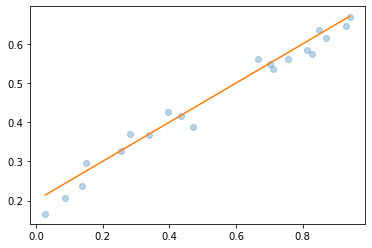

In [244]:
Xtr,ytr = criaDatasetReg()

plotaDatasetRegr(Xtr,ytr)
plotaFuncao(Xtr,ytr,0.5,0.2)
Xtr.shape,ytr.shape

((20, 2), (20,))

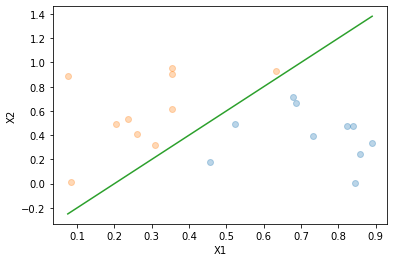

In [255]:
Xtr,ytr = criaDataset()
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,np.array([2,-1]),-0.4)
Xtr.shape,ytr.shape

DEBUG: PSEUDOINV 
0.95
[-1.10746955  2.97031976 -0.81096051]
[]


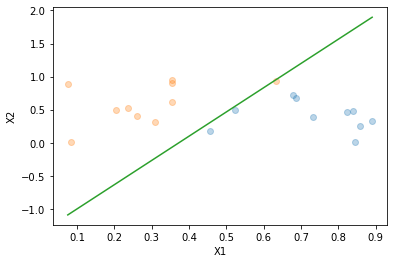

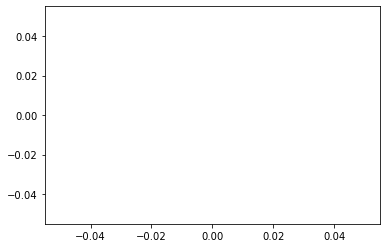

In [257]:
perceptron = Perceptron(max_iter=10000,learning_rate=0.05)
history = perceptron.fit(Xtr,ytr,batch=False,pinv=True)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
print(history)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)


0.961
[-0.75974902  2.53152624 -0.77900844]


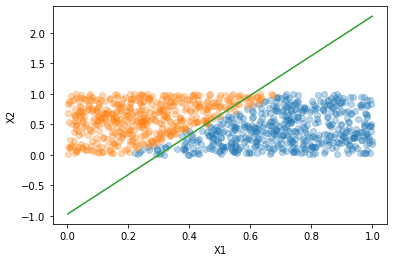

In [238]:
Xtst,ytst = criaDataset(n=1000)
ypred = perceptron.predict(Xtst)
print(sum(ypred==ytst)/len(ytst))
print(perceptron.w)
plotDataset(Xtst,ytst)
plotHiperplano(Xtst,ytst,perceptron.w[1:],perceptron.w[0])